In [1]:
import torch
import matplotlib.pyplot as plt

In [2]:
ts = torch.arange(1, 10).reshape((3,3))
print(ts)
print(ts[1:, 1:])

tensor([[1, 2, 3],
        [4, 5, 6],
        [7, 8, 9]])
tensor([[5, 6],
        [8, 9]])


train torch.Size([60000, 784]) torch.Size([60000])
valid torch.Size([10000, 784]) torch.Size([10000])


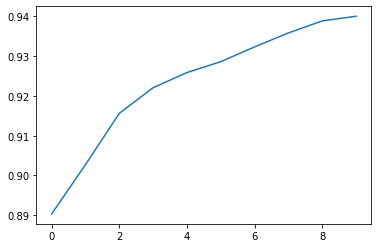

In [5]:
from torchvision import datasets, transforms
from torch import tensor, nn
from torch.optim import SGD
from torch.utils.data import DataLoader as DataL

mnist_train_ds = datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
mnist_valid_ds = datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())
mnist_train = [el for el in mnist_train_ds]
mnist_valid = [el for el in mnist_valid_ds]

def prepare_ds_map(ds):
    train_map = {}
    for (img, num) in ds:
        if num not in train_map:
            train_map[num] = []
        train_map[num].append(img)

    for (num, lst) in train_map.items():
        train_map[num] = torch.stack(train_map[num])
    return train_map

def prepare_ds(ds):
    train_x = tensor([])
    train_y = tensor([])
    for num in range(0, 10):
        train_t = ds[num]
        train_x = torch.cat([train_x, train_t])
        train_y = torch.cat([train_y,
            tensor([num]*len(train_t))
        ])
    train_x = train_x.view(-1, 28*28).float()
    return train_x, train_y.long()

train_map = prepare_ds_map(mnist_train)
train_x, train_y = prepare_ds(train_map)
valid_map = prepare_ds_map(mnist_valid)
valid_x, valid_y = prepare_ds(valid_map)
print('train', train_x.shape, train_y.shape)
print('valid', valid_x.shape, valid_y.shape)

train_ds = list(zip(train_x, train_y))
valid_ds = list(zip(valid_x, valid_y))

lr = 0.1
mnist_net = nn.Sequential(
    nn.Linear(28*28, 40),
    nn.ReLU(),
    nn.Linear(40, 10),
)
opt = SGD(mnist_net.parameters(), lr=lr)
dl = DataL(train_ds, batch_size=256, shuffle=True)
m_loss = nn.CrossEntropyLoss()

def epoch():
    losses = []
    for (it_x, it_y) in dl:
        opt.zero_grad()
        loss = m_loss(mnist_net(it_x), it_y)
        loss.backward()
        opt.step()
        losses.append(loss.item())
    return losses

def my_acc(res, trg):
    return ((res.argmax(dim=1)) == trg).float().mean()

losses = []
valid_dl = DataL(valid_ds, batch_size=256)
accs = []
for i in range(0, 10):
    lss = epoch()
    losses = losses + lss
    accur = tensor([
        my_acc(mnist_net(valid_x), valid_y)
        for (valid_x, valid_y) in valid_dl
    ]).mean()
    accs.append(accur)

#plt.plot(losses);
plt.plot(accs)